In [2]:
# Load Libraries
import gymnasium as gym
from gymnasium import Env, spaces
import pandas as pd
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

In [3]:
# Load dataset
df = pd.read_csv("test_data.csv")
df.fillna(0, inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: 'test_data.csv'

In [ ]:
import numpy as np

# Simulate realistic fares (e.g., between $8 and $15)
np.random.seed(45)
df['base_fare'] = np.random.uniform(8, 15, size=len(df))


In [ ]:
df.head()

,Pickup Location,Request to Pickup,Hour of Day,Time of Day,Month of Year,Surge Pricing Indicator,DWF Reward Applied,Historical Demand Forecast,RPI,incentive,fare_adjustment,DPI,CR,base_fare
0,83,399.0,22,night,9,0,0.00,0.530965,0.162785,2.430558,0.138576,0.058981,0.584045,14.923081
1,42,505.0,0,night,1,0,4.78,0.109357,0.110085,4.966259,0.090042,0.035462,0.603278,11.846813
2,74,419.0,8,morning,7,1,0.00,0.675392,0.252517,3.904764,-0.141491,0.000000,0.576258,9.970131
3,161,141.0,21,night,6,0,0.00,0.493372,0.879803,4.828563,0.007931,0.050947,0.428858,8.541027
4,219,233.0,14,afternoon,6,0,0.00,0.358825,0.641462,3.423757,-0.146606,0.063442,0.479270,11.111286


In [ ]:
def evaluate_cost_by_outcome(model_path, env_class, df):
    env = DummyVecEnv([lambda: env_class(df)])
    model = PPO.load(model_path)
    
    obs = env.reset()
    done = False
    success_costs = []
    cancel_costs = []
    idx = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _ = env.step(action)

        row = df.iloc[idx]
        base_fare = row['base_fare']
        incentive = action[0][1]
        cost = base_fare + incentive

        # ✅ Use CR as a proxy for completion
        if row['CR'] < 0.5:
            success_costs.append(cost)
        else:
            cancel_costs.append(cost)

        idx += 1

    return np.mean(success_costs), np.mean(cancel_costs)


In [ ]:
class RideHailingEnv_Baseline(gym.Env):
    def __init__(self, df):
        super(RideHailingEnv_Baseline, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_idx = 0

        # ⬅️ Only 4 features: no RPI, DPI, CR, HDF
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.action_space = spaces.Box(low=np.array([-0.15, 0.0]), high=np.array([0.15, 5.0]), dtype=np.float32)

    def reset(self):
        self.current_idx = 0
        return self._get_observation()

    def step(self, action):
        if self.current_idx >= len(self.df) - 1:
            return self._get_observation(), 0.0, True, {}

        row = self.df.iloc[self.current_idx]
        fare_adjustment, rider_incentive = action

        reward = 1.0 if row['CR'] < 0.5 else -1.0
        # reward = 1.0
        # if rider_incentive > 3.0:
        #     reward -= 0.5
        # if fare_adjustment < -0.10:
        #     reward -= 0.3

        self.current_idx += 1
        done = self.current_idx >= len(self.df)
        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        if self.current_idx >= len(self.df): 
            return np.zeros(self.observation_space.shape, dtype=np.float32)

        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year']
        ], dtype=np.float32)


In [ ]:
# Define RideHailingEnv_RPI with safe observation handling
class RideHailingEnv_RPI(gym.Env):
    def __init__(self, df):
        super(RideHailingEnv_RPI, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_idx = 0
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)
        self.action_space = spaces.Box(low=np.array([-0.15, 0.0]), high=np.array([0.15, 5.0]), dtype=np.float32)

    def reset(self):
        self.current_idx = 0
        return self._get_observation()

    def step(self, action):
        if self.current_idx >= len(self.df) - 1:
            return self._get_observation(), 0.0, True, {}

        row = self.df.iloc[self.current_idx]
        fare_adjustment, rider_incentive = action
        reward = 1.0 if row['CR'] < 0.5 else -1.0
        # if rider_incentive > 3.0:
        #     reward -= 0.5
        # if fare_adjustment < -0.10:
        #     reward -= 0.3

        self.current_idx += 1
        done = self.current_idx >= len(self.df)
        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        if self.current_idx >= len(self.df): 
            return np.zeros(self.observation_space.shape, dtype=np.float32)

        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year'],
            row['RPI']
        ], dtype=np.float32)

In [ ]:
class RideHailingEnv_RPI_DPI(gym.Env):
    def __init__(self, df):
        super(RideHailingEnv_RPI_DPI, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_idx = 0
        self.observation_space = spaces.Box(low=0, high=1, shape=(6,), dtype=np.float32)
        self.action_space = spaces.Box(low=np.array([-0.15, 0.0]), high=np.array([0.15, 5.0]), dtype=np.float32)

    def reset(self):
        self.current_idx = 0
        return self._get_observation()

    def step(self, action):
        if self.current_idx >= len(self.df) - 1:
            return self._get_observation(), 0.0, True, {}

        row = self.df.iloc[self.current_idx]
        fare_adjustment, rider_incentive = action
        reward = 1.0 if row['CR'] < 0.5 else -1.0
        # if rider_incentive > 3.0: reward -= 0.5
        # if fare_adjustment < -0.10: reward -= 0.3

        self.current_idx += 1
        done = self.current_idx >= len(self.df)
        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        if self.current_idx >= len(self.df):
            return np.zeros(self.observation_space.shape, dtype=np.float32)

        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year'],
            row['RPI'],
            row['DPI']
        ], dtype=np.float32)

In [ ]:
class RideHailingEnv_RPI_DPI_CR(gym.Env):
    def __init__(self, df):
        super(RideHailingEnv_RPI_DPI_CR, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_idx = 0
        self.observation_space = spaces.Box(low=0, high=1, shape=(7,), dtype=np.float32)
        self.action_space = spaces.Box(low=np.array([-0.15, 0.0]), high=np.array([0.15, 5.0]), dtype=np.float32)

    def reset(self):
        self.current_idx = 0
        return self._get_observation()

    def step(self, action):
        if self.current_idx >= len(self.df) - 1:
            return self._get_observation(), 0.0, True, {}

        row = self.df.iloc[self.current_idx]
        fare_adjustment, rider_incentive = action
        reward = 1.0 if row['CR'] < 0.5 else -1.0
        # if rider_incentive > 3.0: reward -= 0.5
        # if fare_adjustment < -0.10: reward -= 0.3

        self.current_idx += 1
        done = self.current_idx >= len(self.df)
        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        if self.current_idx >= len(self.df):
            return np.zeros(self.observation_space.shape, dtype=np.float32)

        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year'],
            row['RPI'],
            row['DPI'],
            row['CR']
        ], dtype=np.float32)


In [ ]:
class RideHailingEnv_HDF(gym.Env):
    def __init__(self, df):
        super(RideHailingEnv_HDF, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_idx = 0
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)
        self.action_space = spaces.Box(low=np.array([-0.15, 0.0]), high=np.array([0.15, 5.0]), dtype=np.float32)

    def reset(self):
        self.current_idx = 0
        return self._get_observation()

    def step(self, action):
        if self.current_idx >= len(self.df) - 1:
            return self._get_observation(), 0.0, True, {}

        row = self.df.iloc[self.current_idx]
        fare_adjustment, rider_incentive = action
        reward = 1.0 if row['CR'] < 0.5 else -1.0
        # if rider_incentive > 3.0: reward -= 0.5
        # if fare_adjustment < -0.10: reward -= 0.3

        self.current_idx += 1
        done = self.current_idx >= len(self.df)
        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        if self.current_idx >= len(self.df):
            return np.zeros(self.observation_space.shape, dtype=np.float32)

        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year'],
            row['Historical Demand Forecast']
        ], dtype=np.float32)


In [ ]:
class RideHailingEnv(gym.Env):
    def __init__(self, df):
        super(RideHailingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_idx = 0

        self.observation_space = spaces.Box(low=0, high=1, shape=(8,), dtype=np.float32)
        self.action_space = spaces.Box(low=np.array([-0.15, 0.0]), high=np.array([0.15, 5.0]), dtype=np.float32)

    def reset(self):
        self.current_idx = 0
        return self._get_observation()

    def step(self, action):
        if self.current_idx >= len(self.df) - 1:
            return self._get_observation(), 0.0, True, {}

        row = self.df.iloc[self.current_idx]
        fare_adjustment, rider_incentive = action

        # Reward logic
        ride_completed = row['CR'] < 0.5
        reward = 1.0 if ride_completed else -1.0
        if rider_incentive > 3.0:
            reward -= 0.5
        if fare_adjustment < -0.10:
            reward -= 0.3

        self.current_idx += 1
        done = self.current_idx >= len(self.df)
        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        if self.current_idx >= len(self.df): 
            return np.zeros(self.observation_space.shape, dtype=np.float32)

        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year'],
            row['RPI'],
            row['DPI'],
            row['CR'],
            row['Historical Demand Forecast']
        ], dtype=np.float32)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode only if not already encoded
if df['Time of Day'].dtype == 'object':
    df['Time of Day'] = LabelEncoder().fit_transform(df['Time of Day'])

if df['Month of Year'].dtype == 'object':
    df['Month of Year'] = LabelEncoder().fit_transform(df['Month of Year'])

if df['Pickup Location'].dtype == 'object':
    df['Pickup Location'] = LabelEncoder().fit_transform(df['Pickup Location'])


In [ ]:
models = {
    "Baseline": ("dwf_rl_baseline_model", RideHailingEnv_Baseline),
    "RPI": ("dwf_rl_RPI_model", RideHailingEnv_RPI),
    "RPI+DPI": ("dwf_rl_RPI_DPI_model", RideHailingEnv_RPI_DPI),
    "RPI+DPI+CR": ("dwf_rl_RPI_DPI_CR_model", RideHailingEnv_RPI_DPI_CR),
    "HDF": ("dwf_rl_HDF_model", RideHailingEnv_HDF),
    "Full DWF": ("dwf_rl_pricing_model_v6", RideHailingEnv)  # If this one includes all 8
}

In [ ]:
# Load model and predict for a sample state
model = PPO.load("dwf_rl_pricing_model_v6")
sample_env = RideHailingEnv(df)
obs = sample_env.reset()
action, _states = model.predict(obs)
print(f"Suggested Fare Adjustment: {action[0]*100:.2f}%")
print(f"Suggested Rider Incentive: ${action[1]:.2f}")

Suggested Fare Adjustment: -15.00%
Suggested Rider Incentive: $0.00


c:\anaconda\envs\analysis\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [ ]:
success_costs = []
cancel_costs = []
labels = []

for name, (model_path, env_class) in models.items():
    success, cancel = evaluate_cost_by_outcome(model_path, env_class, df)
    labels.append(name)
    success_costs.append(success)
    cancel_costs.append(cancel)


c:\anaconda\envs\analysis\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\anaconda\envs\analysis\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


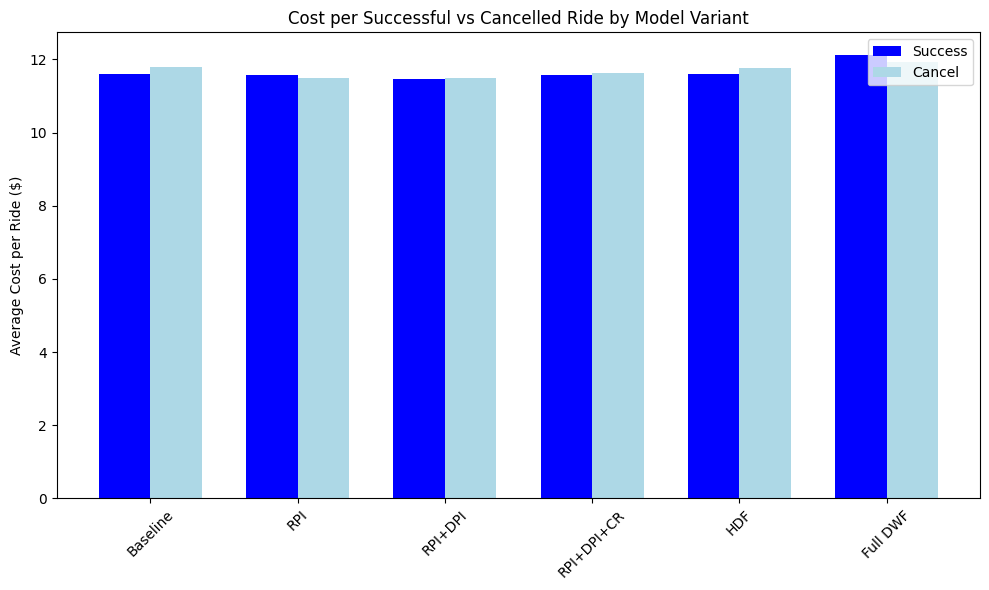

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, success_costs, width, label='Success', color='blue')
ax.bar(x + width/2, cancel_costs, width, label='Cancel', color='lightblue')

ax.set_ylabel('Average Cost per Ride ($)')
ax.set_title('Cost per Successful vs Cancelled Ride by Model Variant')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()
